In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Installation

In [ ]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.6 MB/s 


In [ ]:
!git clone https://github.com/quyen228/YOLOX
%cd YOLOX
!git checkout kiwi
!pip3 install -v -e .  # or  python3 setup.py develop

Cloning into 'YOLOX'...
remote: Enumerating objects: 1775, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1775 (delta 22), reused 29 (delta 11), pack-reused 1723
Receiving objects: 100% (1775/1775), 6.86 MiB | 43.88 MiB/s, done.
Resolving deltas: 100% (1042/1042), done.
/content/YOLOX
Branch 'kiwi' set up to track remote branch 'kiwi' from 'origin'.
Switched to a new branch 'kiwi'
Using pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
Value for scheme.headers does not match. Please report this to <https://

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2
import glob

from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold, train_test_split
from PIL import Image, ImageFilter
from string import Template
from IPython.display import display
from tqdm import tqdm
from bs4 import BeautifulSoup
import lxml
import gdown
import torchvision
from glob import glob
import numpy as np

TRAIN_PATH = 'dataset'

In [ ]:
# check Torch and CUDA version
print(f"Torch: {torch.__version__}")
!nvcc --version

Torch: 1.13.0+cu116
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# Step 2: Data Preparition



## Step 2.1: Prepare data and label base on VOC format



* Firstly, You need to label your data before training. You should clone this repo: ```https://github.com/tzutalin/labelImg```

You also can find the video demo and the usage on the README file of the above repo.

* Next, you copy your images to ./YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages
* Then, you copy your annotations to ./YOLOX/datasets/VOCdevkit/VOC2007/Annotations



In [ ]:
!unzip /content/drive/MyDrive/KNG/kiwi/dataset/kiwi/VOCdevkit.zip -d ./datasets

Archive:  /content/drive/MyDrive/KNG/kiwi/dataset/kiwi/VOCdevkit.zip
   creating: ./datasets/VOCdevkit/
   creating: ./datasets/VOCdevkit/VOC2007/
   creating: ./datasets/VOCdevkit/VOC2007/JPEGImages/
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image002.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image003.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image004.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image006.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image008.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image009.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image010.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image012.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image013.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image015.jpg  
  inflating: ./datasets/VOCdevkit/VOC2007/JPEGIma

In [ ]:
!cp /content/YOLOX/datasets/VOCdevkit/VOC2007/night/train/argument/*.jpg /content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages
!cp /content/YOLOX/datasets/VOCdevkit/VOC2007/night/val/argument/*.jpg /content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages

In [ ]:
import os 

list_data = os.listdir('/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages')
print(len(list_data))

list_anno = os.listdir('/content/YOLOX/datasets/VOCdevkit/VOC2007/Annotations')
print(len(list_anno))

1574
1569


In [ ]:
with open('/content/drive/MyDrive/KNG/kiwi/document/wrong_label.txt') as f:
  wrong = [f'{i.strip()}.jpg' for i in f.readlines()] 

print(len(wrong))

505


In [ ]:
for w in tqdm(wrong): 
  try:
    os.remove(f'/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/{w[:-4]}.jpg')
    os.remove(f'/content/YOLOX/datasets/VOCdevkit/VOC2007/Annotations/{w[:-4]}.xml')
  except:
    continue


100%|██████████| 505/505 [00:00<00:00, 8213.38it/s]


In [ ]:

list_data = os.listdir('/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages')
print(len(list_data))

list_anno = os.listdir('/content/YOLOX/datasets/VOCdevkit/VOC2007/Annotations')
print(len(list_anno))

1069
1066


In [ ]:
!cp /content/drive/MyDrive/KNG/kiwi/dataset/kiwi/v3/val.txt ./datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt

In [ ]:
!cp /content/drive/MyDrive/KNG/kiwi/dataset/kiwi/v3/train.txt ./datasets/VOCdevkit/VOC2007/ImageSets/Main/train.txt 

## Step 2.2: Divide dataset to Train dataset and Val dataset

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os

In [ ]:
data = os.listdir("./datasets/VOCdevkit/VOC2007/Annotations/")
data = [i[:-4] for i in data]
print(len(data))

1066


In [ ]:
X = np.array(data)
y = np.zeros((len(data)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
with open("./datasets/VOCdevkit/VOC2007/ImageSets/Main/train.txt","w") as f:
    for item in X_train:
        f.write("%s\n" % item)
        
with open("./datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt","w") as f:
    for item in X_test:
        f.write("%s\n" % item)
        

In [ ]:
352+714

1066

## Step 2.3: Add classes

In this step, you should add classes in the below tuple VOC_CLASSES.
For example: 
*   if you have two classes: dog and cat. The VOC_CLASSES is:
```VOC_CLASSES = ("dog", "cat", )```

In [ ]:
voc_cls = '''
VOC_CLASSES = (
  "kiwifruit",
)
'''
with open('./yolox/data/datasets/voc_classes.py', 'w') as f:
    f.write(voc_cls)

# coco_cls = '''
# COCO_CLASSES = (    
#   "direction",
#   "stop",
# )
# '''
# with open('./yolox/data/datasets/coco_classes.py', 'w') as f:
#     f.write(coco_cls)

# check if everything is ok    
!more ./yolox/data/datasets/voc_classes.py    


VOC_CLASSES = (
  "kiwifruit",
)


# Tuning Config File

You can tune some parameters before training the model: 
  * self.num_classes: The number of classes in your dataset
    * Default: self.num_classes = 1
  * self.depth: The network depth
    * Default: self.depth = 0.33
  * self.width: The network width
    * Default: self.width = 0.50
  * self.warmup_epochs: 
    * Default: self.warmup_epochs = 1
  * self.mosaic_prob: The probability of Mosaic data augmentation that combines 4 training images into one in certain ratios.
    * Default: self.mosaic_prob = 1.0
  * self.mixup_prob: The probability of Mixup data augmentation that convex overlaying of image pairs and their labels.
    * Default: self.mixup_prob = 0.0
  * self.hsv_prob: The probability of HSV color space 
    * Default: self.hsv_prob = 1.0
  * self.flip_prob: The probability of Flip data augmentation that reverses the pixels rows or column-wise respectively. 
    * Default: self.flip_prob = 0.5
  * self.max_epoch: The number of epoch you want to train
    * Default: self.max_epoch = 50
  * self.test_conf: The confidence threshold
    * Default: self.test_conf = 0.2
  * self.data_num_workers: The cpu will be used 
    * Default: self.data_num_workers = 4
  * self.eval_interval: The interval (epoch) that the model will be evaluated
    * Default: self.eval_interval = 1
  * self.print_interval: The interval (epoch) that the result will be printed on the screen
    * Default: self.print_interval = 100
  * self.input_size: This is the size of the input image 
    * Default: self.input_size = (640,640)
  * self.test_size: This is the size of the test image 
    * Default: self.test_size = (640,640)


In [ ]:
config_file_template = '''

import os

import torch
import torch.distributed as dist

from yolox.data import get_yolox_datadir
from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.output_dir = "/content/drive/MyDrive/KNG/kiwi/model/kiwi/v3.2"
        self.num_classes = 1
        self.max_epoch = 300
        self.depth = 0.33
        self.width = 0.375
        self.input_size = (416, 416)
        self.mosaic_scale = (0.5, 1.5)
        self.mixup_prob = 1.0
        self.hsv_prob = 1.0
        self.flip_prob = 0.5
        self.random_size = (10, 20)
        self.test_size = (416, 416)
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.enable_mixup = False        
        

    def get_data_loader(self, batch_size, is_distributed, no_aug=False, cache_img=False):
        from yolox.data import (
            VOCDetection,
            TrainTransform,
            YoloBatchSampler,
            DataLoader,
            InfiniteSampler,
            MosaicDetection,
            worker_init_reset_seed,
        )
        from yolox.utils import (
            wait_for_the_master,
            get_local_rank,
        )
        local_rank = get_local_rank()

        with wait_for_the_master(local_rank):
            dataset = VOCDetection(
                data_dir=os.path.join(get_yolox_datadir(), "VOCdevkit"),
                image_sets=[('2007', 'train')],
                img_size=self.input_size,
                preproc=TrainTransform(
                    max_labels=50,
                    flip_prob=self.flip_prob,
                    hsv_prob=self.hsv_prob),
                cache=cache_img,
            )

        dataset = MosaicDetection(
            dataset,
            mosaic=not no_aug,
            img_size=self.input_size,
            preproc=TrainTransform(
                max_labels=120,
                flip_prob=self.flip_prob,
                hsv_prob=self.hsv_prob),
            degrees=self.degrees,
            translate=self.translate,
            mosaic_scale=self.mosaic_scale,
            mixup_scale=self.mixup_scale,
            shear=self.shear,
            enable_mixup=self.enable_mixup,
            mosaic_prob=self.mosaic_prob,
            mixup_prob=self.mixup_prob,
        )

        self.dataset = dataset

        if is_distributed:
            batch_size = batch_size // dist.get_world_size()

        sampler = InfiniteSampler(
            len(self.dataset), seed=self.seed if self.seed else 0
        )

        batch_sampler = YoloBatchSampler(
            sampler=sampler,
            batch_size=batch_size,
            drop_last=False,
            mosaic=not no_aug,
        )

        dataloader_kwargs = {"num_workers": self.data_num_workers, "pin_memory": True}
        dataloader_kwargs["batch_sampler"] = batch_sampler

        # Make sure each process has different random seed, especially for 'fork' method
        dataloader_kwargs["worker_init_fn"] = worker_init_reset_seed

        train_loader = DataLoader(self.dataset, **dataloader_kwargs)

        return train_loader

    def get_eval_loader(self, batch_size, is_distributed, testdev=False, legacy=False):
        from yolox.data import VOCDetection, ValTransform

        valdataset = VOCDetection(
            data_dir=os.path.join(get_yolox_datadir(), "VOCdevkit"),
            image_sets=[('2007', 'val')],
            img_size=self.test_size,
            preproc=ValTransform(legacy=legacy),
        )

        if is_distributed:
            batch_size = batch_size // dist.get_world_size()
            sampler = torch.utils.data.distributed.DistributedSampler(
                valdataset, shuffle=False
            )
        else:
            sampler = torch.utils.data.SequentialSampler(valdataset)

        dataloader_kwargs = {
            "num_workers": self.data_num_workers,
            "pin_memory": True,
            "sampler": sampler,
        }
        dataloader_kwargs["batch_size"] = batch_size
        val_loader = torch.utils.data.DataLoader(valdataset, **dataloader_kwargs)

        return val_loader

    def get_evaluator(self, batch_size, is_distributed, testdev=False, legacy=False):
        from yolox.evaluators import VOCEvaluator

        val_loader = self.get_eval_loader(batch_size, is_distributed, testdev, legacy)
        evaluator = VOCEvaluator(
            dataloader=val_loader,
            img_size=self.test_size,
            confthre=self.test_conf,
            nmsthre=self.nmsthre,
            num_classes=self.num_classes,
        )
        return evaluator

'''

In [ ]:
PIPELINE_CONFIG_PATH='cots_config.py'

pipeline = Template(config_file_template).substitute()

with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

# Download pretrained model

In [ ]:
# !wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_tiny.pth
!cp /content/drive/MyDrive/KNG/kiwi/model/kiwi/v3/cots_config/best_ckpt.pth yolox_tiny.pth

In [ ]:
# this is the path of the pretrained model that you downloaded
MODEL_FILE = 'yolox_tiny.pth'

# Train Model

REFERENCES:

-f: the path of the config file

-d: the device for training (1, 4, 8, 16, 32)

-b: batch size 

-c: the path of the pretrained model (EX: yolos)

In [ ]:
!python tools/train.py \
    -f cots_config.py \
    -d 1 \
    -b 32 \
    --fp16 \
    -o \
    -c {MODEL_FILE}

2022-12-21 07:58:18 | INFO     | yolox.core.trainer:130 - args: Namespace(batch_size=32, cache=False, ckpt='yolox_tiny.pth', devices=1, dist_backend='nccl', dist_url=None, exp_file='cots_config.py', experiment_name='cots_config', fp16=True, logger='tensorboard', machine_rank=0, name=None, num_machines=1, occupy=True, opts=[], resume=False, start_epoch=None)
2022-12-21 07:58:19 | INFO     | yolox.core.trainer:131 - exp value:
╒═══════════════════╤═══════════════════════════════════════════════════╕
│ keys              │ values                                            │
╞═══════════════════╪═══════════════════════════════════════════════════╡
│ seed              │ None                                              │
├───────────────────┼───────────────────────────────────────────────────┤
│ output_dir        │ '/content/drive/MyDrive/KNG/kiwi/model/kiwi/v3.2' │
├───────────────────┼───────────────────────────────────────────────────┤
│ print_interval    │ 10                             

In [ ]:
!cp -r /content/YOLOX/datasets/VOCdevkit/annotations_cache /content/drive/MyDrive/KNG/kiwi/result/kiwi/v3.2

In [ ]:
!cp -r /content/YOLOX/datasets/VOCdevkit/results /content/drive/MyDrive/KNG/kiwi/result/kiwi/v3.2/

# Evaluation

In [ ]:
# from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

# you need to add classes in your dataset
VOC_CLASSES = (
  "kiwifruit",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# set inference parameters, you can tune them
test_size = (416, 416)
num_classes = 1
confthre = 0.15
nmsthre = 0.1


# get YOLOX model
model = exp.get_model()
# model.cuda()
model.eval()

# get custom trained checkpoint
# this is the path of .pth file that you trained
ckpt_file = '/content/drive/MyDrive/KNG/kiwi/model/kiwi/v3.2/cots_config/best_ckpt.pth'
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
def preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):
    # copy the prediction tensor to box_corner tensor
    # print(prediction[:, :, 0][0].tolist())     
    box_corner = prediction.new(prediction.shape)    
    # print(box_corner[:, :, 0][0].tolist())    
    # convert xywh to x1y1x2y2        
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    # print(box_corner[:, :, 0][0].tolist())
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    class_conf, class_pred = torch.max(prediction[0][:, 5: 5 + num_classes], 1, keepdim=True) 
    conf_mask = (prediction[0][:, 4] * class_conf.squeeze() >= 0.1).squeeze()
    # print(class_conf)
    # print(class_pred.shape)
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output

In [ ]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    # tensor_img = tensor_img.cuda()
    with torch.no_grad():
        outputs = model(tensor_img)
        # print(outputs.shape)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )
    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores

In [ ]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    out_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # image = Image.fromarray(out_image)
    count = 0
    for i in range(len(bboxes)):
        if len(bboxes) == 0:
            break
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        count += 1
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])
        # smol_image = image.crop((x0, y0, x1, y1))
        # blurred_image = smol_image.filter(ImageFilter.GaussianBlur(radius=20))
        # image.paste(blurred_image, (x0, y0))            
        cv2.rectangle(out_image, (x0, y0), (x1, y1), (255, 0, 255), 1)     
        # cv2.putText(out_image, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0-3, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), thickness = 2)
    h, w = out_image.shape[:2]
    x, y = 10, h // 8
    fs = min(h, w) // 200
    cv2.putText(out_image, f"Count: {count}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, fs, color=(255, 0, 0), thickness=fs)
    return out_image


## Single Image

In [ ]:
# you need to change the test image path
TEST_IMAGE_PATH = "/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/A0-0-1-image016.jpg"
img = cv2.imread(TEST_IMAGE_PATH)
original = img.copy()

153


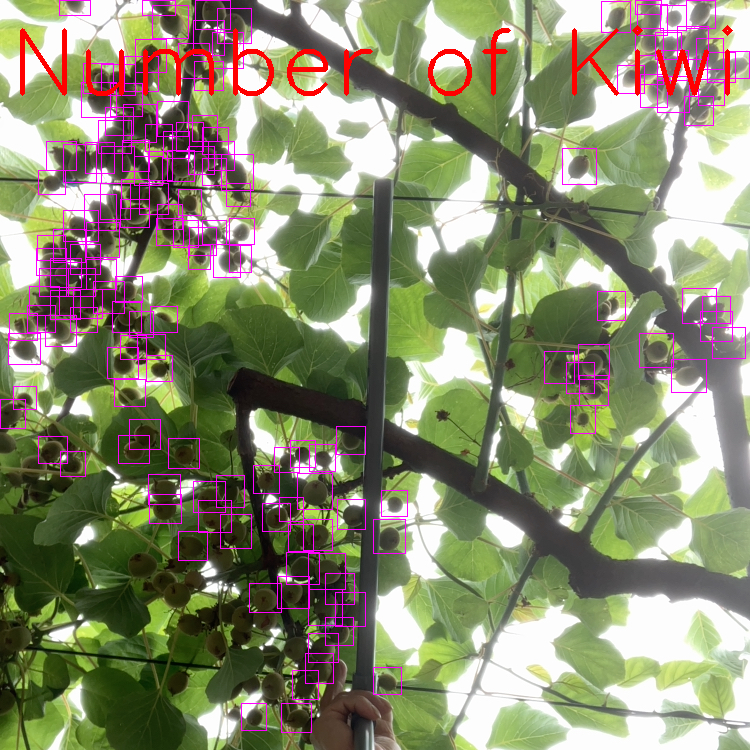

In [ ]:
img_name = TEST_IMAGE_PATH.split("/")[-1]
# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)
print(len(bboxes))
# Draw predictions
# pred_bndbox['PartA_01377'] = to_tuple_bbox(bboxes)
# print(to_tuple_bbox(bboxes))
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, VOC_CLASSES)
# print(scores)
# Since we load image using OpenCV we have to convert it 
# out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

# Image.fromarray(out_image).save(f"/content/drive/MyDrive/kng/car_plate/result/{img_name}")
# cv2.imwrite(f"/content/drive/MyDrive/kng/car_plate/result/{img_name}", out_image)

### fix dark-light

#### convert to YCrCb

In [ ]:
img = cv2.imread(TEST_IMAGE_PATH)
original = img.copy()
imgYCC = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

#### get Y 

In [ ]:
imgY = imgYCC[:, :, 0]

#### histogram equalization

In [ ]:
equal_hist = cv2.equalizeHist(imgY)

In [ ]:
imgYCC[:, :, 0] = equal_hist

#### YCrCb to BGR

In [ ]:
imgBGR = cv2.cvtColor(imgYCC, cv2.COLOR_YCR_CB2BGR)

In [ ]:
Image.fromarray(imgBGR)

## Multiple Images

In [ ]:
# test = []
with open("/content/YOLOX/datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt") as test_file:
  test = [t.strip() for t in test_file.readlines()]

# test = glob.glob('/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/*')
print(len(test))

351


In [ ]:
# import random  

# random_test = [random.choice(test) for i in range(100)]
# print(random_test)

In [ ]:
import base64
from PIL import Image
import io


def to_tuple_bbox(tensor_bboxs):
  try:
    list_bboxs = tensor_bboxs.tolist()
  except:
    list_bboxs = tensor_bboxs
  int_list_bboxs = []
  for bboxs in list_bboxs:
    int_tuple_bboxs = []
    for bbox in bboxs:
      int_tuple_bboxs.append(int(bbox))
    int_list_bboxs.append(tuple(int_tuple_bboxs))
  return int_list_bboxs


def get_list_bndbox(tensor_bboxs):   
  try:
    list_bboxs = tensor_bboxs.tolist() 
  except:
    list_bboxs = tensor_bboxs
  list_bndbox = []
  for bndbox in list_bboxs:
    dict_bndbox = {}
    dict_bndbox['xmin'] = bndbox[0]
    dict_bndbox['ymin'] = bndbox[1]
    dict_bndbox['xmax'] = bndbox[2]
    dict_bndbox['ymax'] = bndbox[3]
    list_bndbox.append(dict_bndbox)
  return list_bndbox


def img_to_base64(img_path):
  with open(img_path, "rb") as img_file:
    my_string = base64.b64encode(img_file.read())
  return my_string.decode('utf-8')


def nparray_to_base64(nparray):
  img = nparray.astype(np.uint8)
  pil_img = Image.fromarray(img)
  buff = io.BytesIO()
  pil_img.save(buff, format = 'PNG')
  encrypted_image = base64.b64encode(buff.getvalue()).decode('utf-8')
  return encrypted_image


def base64_to_img(base64_string):
    imgdata = base64.b64decode(base64_string)
    imgbyte = io.BytesIO(imgdata)
    img = Image.open(imgbyte)
    return img 

In [ ]:
!mkdir /content/result_kiwi_v3.2

In [ ]:
wrong = []
pred_bndbox = dict()
dict_result = {}

for t in tqdm(test):
  TEST_IMAGE_PATH = f'/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/{t.strip()}.jpg'
  img = cv2.imread(TEST_IMAGE_PATH)
  original = img.copy()
  img_name = TEST_IMAGE_PATH.split("/")[-1]
  # Get predictions
  bboxes, bbclasses, scores = yolox_inference(img, model, test_size)
  # Draw predictions
  out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, VOC_CLASSES)  
  Image.fromarray(out_image).save(f"/content/result_kiwi_v3.2/{img_name}")

  # IOU
  pred_bndbox[img_name] = to_tuple_bbox(bboxes)
  list_bndbox = get_list_bndbox(bboxes)

  dict_result[img_name] = {}
  dict_result[img_name]['input'] = img_to_base64(TEST_IMAGE_PATH)
  dict_result[img_name]['bndbox'] = list_bndbox
  dict_result[img_name]['output'] = nparray_to_base64(out_image)
    

100%|██████████| 351/351 [02:26<00:00,  2.39it/s]


In [ ]:
# display(base64_to_img((dict_result['20151124T024547.596676_i2459j666.png']['input'])))
# display(base64_to_img((dict_result['20151124T024547.596676_i2459j666.png']['output'])))

In [ ]:
!zip -r /content/drive/MyDrive/KNG/kiwi/result/kiwi/v3/v3.zip /content/v3
# !zip -r /content/drive/MyDrive/KNG/kiwi/result/kiwi/wrong_kiwi_v2.zip /content/YOLOX/wrong_kiwi_v2/

In [ ]:
import json 

# with open("/content/result_random10.json", "w") as outfile:
#   json.dump(dict_result, outfile)

with open("/content/drive/MyDrive/KNG/kiwi/result/kiwi/v3.2/pred_bndbox.json", "w") as outfile:
  json.dump(pred_bndbox, outfile)

## count object

In [ ]:
with open("/content/YOLOX/datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt") as f:
  val = [name.strip() for name in f.readlines()]

print(len(val))

351


In [ ]:
with open("/content/drive/MyDrive/KNG/kiwi/result/kiwi/v3/pred_bndbox.json") as f:
  prd = json.load(f)

print(len(prd))  

351


In [ ]:
def get_bndbox(annotation):
    content = []
    # Read the XML file
    with open(annotation, "r") as file:
        # Read each line in the file, readlines() returns a list of lines
        content = file.readlines()
        # Combine the lines in the list into a string
        content = "".join(content)
        bs_content = BeautifulSoup(content, "lxml")
    list_bbox = bs_content.find_all('bndbox')
    bndbox = [(int(bbox.find('xmin').string), int(bbox.find('ymin').string), int(bbox.find('xmax').string), int(bbox.find('ymax').string)) for bbox in list_bbox]
    return bndbox

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
import pandas as pd

df_metrics = pd.DataFrame(columns=["image_name", "mean_iou", "TP", "FP"])
dict_iou = dict()
true = 0
TP = 0
FP = 0 
data = []

for v in tqdm(val):
  dict_iou[v] = []
  pd_bbox = prd[f"{v}.jpg"]

  annotation = f"/content/YOLOX/datasets/VOCdevkit/VOC2007/Annotations/{v}.xml" 
  gt_bbox = get_bndbox(annotation)

  sum_iou = 0 
  tp = 0
  fp = 0
  for pdb in pd_bbox:
    max_iou = 0
    for gtb in gt_bbox:
      iou = bb_intersection_over_union(gtb, pdb)
      if iou > max_iou:
        max_iou = iou
    sum_iou += max_iou
    dict_iou[v].append(max_iou)

    if max_iou >= 0.1:
      TP += 1
      tp += 1
    else:
      FP += 1
      fp += 1

  if len(pd_bbox) == 0:
    mean_iou = 0
  else:
    mean_iou = sum_iou/len(pd_bbox)

  data.append([v, mean_iou, tp, fp])

df_metrics = pd.DataFrame(data, columns=["image_name", "mean_iou", "TP", "FP"])


100%|██████████| 351/351 [00:06<00:00, 56.69it/s]


In [ ]:
df_metrics['Cumulative TP'] = df_metrics['TP'].cumsum()
df_metrics['Cumulative FP'] = df_metrics['FP'].cumsum()
df_metrics['Precision'] = df_metrics.apply(lambda col: \
                                                col['Cumulative TP']/(col['Cumulative TP']+col['Cumulative FP']), \
                                                axis=1)

In [ ]:
df_metrics

image_name  mean_iou  TP  FP  Cumulative TP  Cumulative FP  \
0    B1-4-1-image019  0.714319  27   2             27              2   
1    B2-3-1-image039  0.726618   3   0             30              2   
2    A1-0-1-image193  0.880637   4   0             34              2   
3    A2-0-1-image139  0.860061  12   0             46              2   
4    A2-0-1-image193  0.733561  65   3            111              5   
..               ...       ...  ..  ..            ...            ...   
346  B2-1-1-image111  0.773145  35   0           8103           1470   
347  A3-1-1-image033  0.442995  70  39           8173           1509   
348  A0-2-2-image002  0.756625   8   1           8181           1510   
349  A3-2-1-image007  0.554636  76  14           8257           1524   
350  A0-2-2-image029  0.860759  13   0           8270           1524   

     Precision  
0     0.931034  
1     0.937500  
2     0.944444  
3     0.958333  
4     0.956897  
..         ...  
346   0.846443  
347   0.844144  
348   0.844185  
349   0.844188  
350   0.844395  

[351 rows x 7 columns]

In [ ]:
sum(df_metrics['mean_iou'])/len(df_metrics['mean_iou'])

0.6133066362702247

In [ ]:
precision = TP/(TP+FP)
print(precision)

0.8443945272615887


In [ ]:
df_metrics.to_csv("/content/drive/MyDrive/KNG/kiwi/result/kiwi/v3/precision.csv", index=False, header=True)

In [ ]:
!zip /content/drive/MyDrive/KNG/kiwi/result/kiwi/v3/result_kiwi_v3.zip -r /content/result_kiwi_v3

# IOU

## Get grouth true bbox

In [ ]:
def get_bndbox(annotation):
    content = []
    # Read the XML file
    with open(annotation, "r") as file:
        # Read each line in the file, readlines() returns a list of lines
        content = file.readlines()
        # Combine the lines in the list into a string
        content = "".join(content)
        bs_content = BeautifulSoup(content, "lxml")
    list_bbox = bs_content.find_all('bndbox')
    bndbox = [(int(bbox.find('xmin').string), int(bbox.find('ymin').string), int(bbox.find('xmax').string), int(bbox.find('ymax').string)) for bbox in list_bbox]
    return bndbox

In [ ]:
dict_bbox = dict()
for t in tqdm(val):
    annotation = f"/content/YOLOX/datasets/VOCdevkit/VOC2007/Annotations/{t}.xml"
    name = annotation.split("/")[-1][:-4]
    bndbox = get_bndbox(annotation)
    dict_bbox[name] = bndbox

100%|██████████| 351/351 [00:06<00:00, 53.83it/s]


In [ ]:
dict_bbox[val[0]]

[(110, 587, 135, 609),
 (147, 616, 171, 637),
 (160, 593, 178, 615),
 (180, 609, 204, 632),
 (76, 603, 102, 629),
 (86, 626, 109, 648),
 (66, 636, 93, 660),
 (175, 696, 203, 731),
 (419, 566, 441, 585),
 (429, 582, 448, 603),
 (477, 586, 499, 611),
 (446, 648, 473, 681),
 (424, 667, 451, 690),
 (434, 677, 462, 698),
 (430, 690, 456, 719),
 (399, 681, 428, 706),
 (413, 700, 433, 721),
 (397, 715, 419, 736),
 (414, 722, 436, 748),
 (368, 699, 396, 724),
 (374, 717, 394, 738),
 (352, 722, 371, 740),
 (365, 727, 382, 750),
 (294, 725, 316, 745),
 (488, 710, 507, 731),
 (490, 726, 515, 750),
 (535, 689, 554, 709),
 (530, 714, 557, 736),
 (549, 705, 580, 727),
 (568, 718, 586, 734),
 (576, 723, 597, 743),
 (615, 692, 646, 720),
 (695, 693, 723, 719),
 (583, 659, 604, 684),
 (563, 668, 595, 695)]

## Calculate IOU

In [ ]:
# image_path = "/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/PartA_00975.jpg"
# gt = dict_bbox["PartA_00975"][0]
# pred = tuple([int(bbox) for bbox in bboxes.tolist()[0]])

In [ ]:
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
def calculate_iou(image_path, gt, pred):
  detection = Detection(image_path, gt, pred)
  # load the image
  # image = cv2.imread(detection.image_path)
  # draw the ground-truth bounding box along with the predicted
  # bounding box
  # cv2.rectangle(image, detection.gt[:2], detection.gt[2:], (0, 255, 0), 2)
  # cv2.rectangle(image, detection.pred[:2], detection.pred[2:], (0, 0, 255), 2)
  # compute the intersection over union and display it
  iou = bb_intersection_over_union(detection.gt, detection.pred)
  # cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
    # cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
  # print("{}: {:.4f}".format(detection.image_path, iou))
  return iou
  # display(Image.fromarray(image))

In [ ]:
dict_iou = dict()

In [ ]:
pd[f'{val[0]}.jpg']

[[619, 60, 662, 106],
 [624, 145, 669, 192],
 [676, 664, 728, 717],
 [628, 639, 675, 689],
 [633, 722, 679, 749]]

In [ ]:
for t in tqdm(test):
  list_iou = []
  image_path = f'/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/{t.strip()}.jpg'
  for pred in pred_bndbox[f'{t}.jpg']:
    max_iou = 0
    for gt in dict_bbox[t]:
      iou = calculate_iou(image_path, gt, pred)
      if iou > max_iou:
        max_iou = iou
    list_iou.append(max_iou)
  dict_iou[t] = list_iou

100%|██████████| 518/518 [00:04<00:00, 105.21it/s]


In [ ]:
len(dict_iou)

518

In [ ]:
from statistics import mean

dict_mean = dict()
for name, bbox in tqdm(dict_iou.items()):
  try:
    dict_mean[name] = mean(bbox)
  except:
    pass

100%|██████████| 518/518 [00:00<00:00, 9630.45it/s]


In [ ]:
sum(dict_mean.values())/len(dict_mean)

0.5863362098146939

In [ ]:
sum(dict_mean.values())/len(dict_mean)

0.6112855941179145

# Convert to TorchScript

In [ ]:
!mv /content/YOLOX/car_plate.pt /content/drive/MyDrive/KNG/car_plate/model

In [ ]:
%cd /content/YOLOX
!python tools/export_torchscript.py --output-name ./car_plate.pt -n yolox_s -f /content/cots_config.py -c /content/epoch_4_ckpt.pth

/content/YOLOX
2022-11-19 04:33:10.583 | INFO     | __main__:main:48 - args value: Namespace(batch_size=1, ckpt='/content/epoch_4_ckpt.pth', decode_in_inference=False, exp_file='/content/cots_config.py', experiment_name=None, name='yolox_s', opts=[], output_name='./car_plate.pt')
2022-11-19 04:33:10.907 | INFO     | __main__:main:71 - loading checkpoint done.
2022-11-19 04:33:15.720 | INFO     | __main__:main:76 - generated torchscript model named ./car_plate.pt


In [ ]:
def preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r


def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):    
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]
      
    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)        
        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        
        detections = detections[conf_mask]    
        
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        detections = detections[nms_out_index]                      

        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))                

    return output


def yolox_inference(img, model, confthre, nmsthre, test_size=(416, 416), num_classes=1):
    tensor_img, _ = preproc(img, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )
    if outputs[0] is None:
        return [], [], []    
    outputs = outputs[0].cpu()
    print(outputs)
    bboxes = outputs[:, 0:4]
    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    return bboxes, bbclasses, scores


def draw_yolox_predictions(img, bboxes, scores, confthre, is_save=0):
    out_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    list_bndbox = []
    list_label = []
    count = 0
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        count += 1
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = int(box[2])
        y1 = int(box[3])
        list_bndbox.append((x0, y0, x1, y1))
        # HEAD: 0
        # FACE: 1
        list_label.append(cls_id)
        cv2.rectangle(img=out_image, pt1=(x0, y0), pt2=(x1, y1), color=(0, 255, 0), thickness=2)
    h, w = out_image.shape[:2]
    x, y = 10, h // 8
    fs = min(h, w) // 200
    cv2.putText(out_image, f"count: {count}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, fs, color=(255, 69, 0), thickness=fs)
    Image.fromarray(out_image).save(f"/content/result.jpg")
    return out_image

tensor([[ 1.4018e+02,  2.8283e+02,  1.6033e+02,  3.0220e+02,  9.9198e-01,
          8.5981e-01,  0.0000e+00],
        [ 1.6316e+02,  3.3452e+02,  1.8496e+02,  3.5835e+02,  9.8704e-01,
          8.5146e-01,  0.0000e+00],
        [ 3.0066e+02,  2.8584e+02,  3.2305e+02,  3.0558e+02,  9.9357e-01,
          8.3808e-01,  0.0000e+00],
        [ 1.6316e+02,  3.0835e+02,  1.8242e+02,  3.2868e+02,  9.9256e-01,
          8.3880e-01,  0.0000e+00],
        [ 1.2709e+02,  3.0004e+02,  1.4518e+02,  3.1787e+02,  9.8952e-01,
          8.3966e-01,  0.0000e+00],
        [ 2.6489e+02,  2.5223e+02,  2.8591e+02,  2.7170e+02,  9.9391e-01,
          8.3033e-01,  0.0000e+00],
        [ 1.4788e+02,  2.9825e+02,  1.6664e+02,  3.1771e+02,  9.9385e-01,
          8.2871e-01,  0.0000e+00],
        [ 1.5517e+02,  2.3762e+02,  1.7407e+02,  2.5703e+02,  9.9300e-01,
          8.2765e-01,  0.0000e+00],
        [ 3.0174e+02,  3.3428e+02,  3.2378e+02,  3.5529e+02,  9.9240e-01,
          8.2675e-01,  0.0000e+00],
        [ 

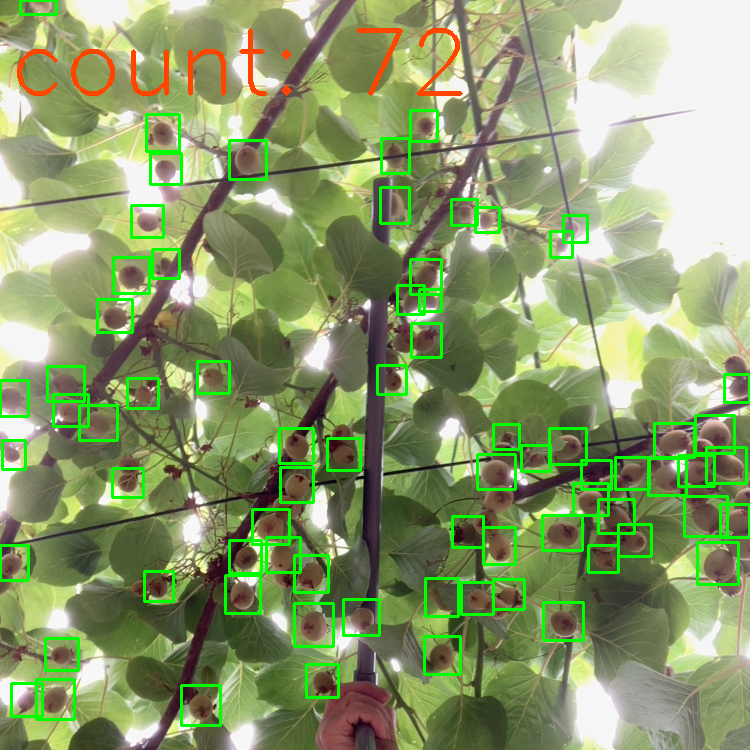

In [ ]:
model_path = '/content/drive/MyDrive/KNG/kiwi/model/kiwi/kiwi_tiny_decode.pt'
input_image = '/content/drive/MyDrive/KNG/kiwi/dataset/kiwi/sample/A0-0-1-image003.jpg'
# Number of classes
num_classes = 1
# Condidence threshold
confthre = 0.1
# Non maximum suppression threshold
nmsthre = 0.1

# Load model    
model = torch.jit.load(model_path, 'cpu')
model.eval()

# Detect
img = cv2.imread(input_image)
original = img.copy()
# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, confthre, nmsthre, test_size=(416, 416), num_classes=num_classes)
# Draw predictions
# assert len(bboxes) > 0, "\nCannot find the object in this image."
out_image = draw_yolox_predictions(img, bboxes, scores, confthre)
display(Image.fromarray(out_image))


In [ ]:
img.shape

(750, 750, 3)

In [ ]:
tensor_img.shape

(416, 416, 3)

In [ ]:
cv2.imwrite('/content/pre.jpg', tensor_img)

True

# Convert to ONNX

In [ ]:
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()
# get YOLOX model
model = exp.get_model()
model.eval()
# get custom trained checkpoint
# this is the path of .pth file that you trained
ckpt_file = "/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/cots_config/best_ckpt.pth"
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [ ]:
!python3 tools/export_onnx.py --output-name /content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.onnx -f /content/YOLOX/cots_config.py -c /content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/cots_config/best_ckpt.pth

2022-11-12 08:07:24.573 | INFO     | __main__:main:64 - args value: Namespace(batch_size=1, ckpt='/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/cots_config/best_ckpt.pth', decode_in_inference=False, dynamic=False, exp_file='/content/YOLOX/cots_config.py', experiment_name=None, input='images', name=None, no_onnxsim=False, opset=11, opts=[], output='output', output_name='/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.onnx')
2022-11-12 08:07:24.781 | INFO     | __main__:main:88 - loading checkpoint done.
2022-11-12 08:07:30.324 | INFO     | __main__:main:101 - generated onnx model named /content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.onnx
2022-11-12 08:07:31.216 | INFO     | __main__:main:117 - generated simplified onnx model named /content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.onnx


In [ ]:
from PIL import Image

img = Image.open('/content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/20151124T031139.816734_i1597j1282.png')

In [ ]:
%cd /content/YOLOX/demo/ONNXRuntime
!python3 onnx_inference.py -m /content/YOLOX/mango_tiny_non-decode.onnx -i /content/YOLOX/datasets/VOCdevkit/VOC2007/JPEGImages/20151124T031139.816734_i1597j1282.png -o r1.jpg -s 0.3 --input_shape 416,416

/content/YOLOX/demo/ONNXRuntime


# Convert to ncnn

In [ ]:
%cd /content 
!git clone https://github.com/Tencent/ncnn.git
%cd ncnn
!git submodule update --init

/content/ncnn


In [ ]:
!sudo apt install build-essential git cmake libprotobuf-dev protobuf-compiler libvulkan-dev vulkan-utils libopencv-dev

In [ ]:
!wget https://sdk.lunarg.com/sdk/download/1.2.189.0/linux/vulkansdk-linux-x86_64-1.2.189.0.tar.gz?Human=true -O vulkansdk-linux-x86_64-1.2.189.0.tar.gz
!tar -xf vulkansdk-linux-x86_64-1.2.189.0.tar.gz
!export VULKAN_SDK=$(pwd)/1.2.189.0/x86_64

In [ ]:
# %cd ncnn
!mkdir -p build
%cd build
!cmake -DCMAKE_BUILD_TYPE=Release -DCMAKE_TOOLCHAIN_FILE=../toolchains/jetson.toolchain.cmake -DNCNN_VULKAN=ON -DNCNN_BUILD_EXAMPLES=ON ..
!make -j$(nproc)

/content/ncnn/examples/build/build
CMake Warning (dev) in CMakeLists.txt:
  No project() command is present.  The top-level CMakeLists.txt file must
  contain a literal, direct call to the project() command.  Add a line of
  code such as

    project(ProjectName)

  near the top of the file, but after cmake_minimum_required().

  CMake is pretending there is a "project(Project)" command on the first
  line.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The C compiler identification is unknown
-- The CXX compiler identification is unknown
CMake Error in CMakeLists.txt:
  The CMAKE_C_COMPILER:

    aarch64-linux-gnu-gcc

  is not a full path and was not found in the PATH.

  Tell CMake where to find the compiler by setting either the environment
  variable "CC" or the CMake cache entry CMAKE_C_COMPILER to the full path to
  the compiler, or to the compiler name if it is in the PATH.


CMake Error in CMakeLists.txt:
  The CMAKE_CXX_COMPILER:

    aarch64-linux-

In [ ]:
%cd /content/ncnn/examples
# ../build/examples/squeezenet ../images/256-ncnn.png

/content/ncnn/examples


In [ ]:
%cd /content/ncnn/tools/onnx

/content/ncnn/tools/onnx


In [ ]:
!cp /content/YOLOX/yolox_s.onnx /content/drive/MyDrive/KNG/kiwi/model

In [ ]:
onnx2ncnn /content/YOLOX/yolox_s.onnx model.param model.bin

SyntaxError: ignored

# Convert to tflite

## convert

In [ ]:
onnx_path = '/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.onnx'

In [ ]:
!pip install onnx-tf
!pip install onnxruntime

In [ ]:
from onnx_tf.backend import prepare
import onnx
import onnxruntime
import numpy as np
import tensorflow as tf

In [ ]:
rng = np.random.default_rng() # set seed if desired
dummy_input = rng.random((1, 3, 416, 416), dtype=np.float32)
# dummy_input

In [ ]:
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %images[FLOAT, 1x3x416x416]
) initializers (
  %head.cls_preds.0.weight[FLOAT, 1x96x1x1]
  %head.cls_preds.0.bias[FLOAT, 1]
  %head.cls_preds.1.weight[FLOAT, 1x96x1x1]
  %head.cls_preds.1.bias[FLOAT, 1]
  %head.cls_preds.2.weight[FLOAT, 1x96x1x1]
  %head.cls_preds.2.bias[FLOAT, 1]
  %head.reg_preds.0.weight[FLOAT, 4x96x1x1]
  %head.reg_preds.0.bias[FLOAT, 4]
  %head.reg_preds.1.weight[FLOAT, 4x96x1x1]
  %head.reg_preds.1.bias[FLOAT, 4]
  %head.reg_preds.2.weight[FLOAT, 4x96x1x1]
  %head.reg_preds.2.bias[FLOAT, 4]
  %head.obj_preds.0.weight[FLOAT, 1x96x1x1]
  %head.obj_preds.0.bias[FLOAT, 1]
  %head.obj_preds.1.weight[FLOAT, 1x96x1x1]
  %head.obj_preds.1.bias[FLOAT, 1]
  %head.obj_preds.2.weight[FLOAT, 1x96x1x1]
  %head.obj_preds.2.bias[FLOAT, 1]
  %onnx::Conv_878[FLOAT, 24x12x3x3]
  %onnx::Conv_879[FLOAT, 24]
  %onnx::Conv_881[FLOAT, 48x24x3x3]
  %onnx::Conv_882[FLOAT, 48]
  %onnx::Conv_884[FLOAT, 24x48x1x1]
  %onnx::Conv_885[FLOAT, 24]
  %onnx::Conv_887[FLOAT, 24x4

In [ ]:
ort_session = onnxruntime.InferenceSession(onnx_path)
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input}
ort_outs = ort_session.run(None, ort_inputs)[0]
# ort_outs

In [ ]:
tf_rep = prepare(onnx_model) 
tf_out = tf_rep.run(np.asarray(dummy_input))[0]
# tf_out

In [ ]:
if np.testing.assert_allclose(ort_outs, tf_out, rtol=1e-03, atol=1e-05) is None:
  tf_rep.export_graph('/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.pb')

In [ ]:
def convert_tf_to_tflite(tf_path, tf_lite_path):
    """
        Converts TF saved model into TFLite model
        :param tf_path: TF saved model path to load
        :param tf_lite_path: TFLite model path to save
    """
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
    tflite_model  = converter.convert()
    with open(tf_lite_path, 'wb') as f:
        f.write(tflite_model)

In [ ]:
tf_model_path = "/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.pb"
tflite_model_path ="/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.tflite"

convert_tf_to_tflite(tf_model_path, tflite_model_path)

In [ ]:
tflite_model_path = "/content/drive/MyDrive/KNG/kiwi/model/kiwi/v2/kiwi_tiny_non-decode_v2.tflite"
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
# input_shape = input_details[0]['shape']
input_data = np.array(dummy_input, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

array([[[ 1.4044672e+00,  1.4115206e+00,  9.9634713e-01,  9.6511775e-01,
          7.6131322e-03,  5.1522231e-01],
        [ 5.8527291e-01,  1.4422513e+00,  1.1992705e+00,  1.0119680e+00,
          5.3688795e-03,  4.9082693e-01],
        [ 5.1070455e-02,  1.2768421e+00,  1.4556644e+00,  7.9071063e-01,
          3.2966321e-03,  3.9257964e-01],
        ...,
        [ 7.4815385e-02,  3.3377089e-02,  2.7201109e+00,  2.3630693e+00,
          1.7336749e-04,  1.1001257e-02],
        [-1.9231907e-01, -2.1127746e-02,  2.5912433e+00,  2.3209941e+00,
          2.2832918e-04,  1.3584347e-02],
        [-6.4085789e-02,  2.6304168e-01,  2.2312281e+00,  2.0652111e+00,
          6.6430970e-05,  2.3559500e-02]]], dtype=float32)

In [ ]:
np.testing.assert_allclose(output_data, tf_out, rtol=1e-03, atol=1e-05)

## test

In [ ]:
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf


In [ ]:
def preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r

In [ ]:
def load_model(path):
    # Load model tf lite from file
    model = tf.lite.Interpreter(path)
    # Allocate tensor
    model.allocate_tensors()

    return model

In [ ]:
input_image = '/content/2.jpg'

# Detect
img = cv2.imread(input_image)
original = img.copy()

# preprocessing image
tensor_img, _ = preproc(img, input_size=(416, 416))

 # Prediction
model = load_model("/content/drive/MyDrive/KNG/head_human/head-face/model/head_face_tiny_decode.tflite")
input_details = model.get_input_details()
output_details = model.get_output_details()
model.set_tensor(input_details[0]['index'], tensor_img[tf.newaxis,...])
model.invoke()
output_data = model.get_tensor(output_details[0]['index'])[0]

In [ ]:
bboxes = np.copy(output_data)
# convert xywh to xyxy and scale to original size
bboxes[:, 0] = output_data[:, 0] - output_data[:, 2]/2
bboxes[:, 1] = output_data[:, 1] - output_data[:, 3]/2
bboxes[:, 2] = output_data[:, 0] + output_data[:, 2]/2
bboxes[:, 3] = output_data[:, 1] + output_data[:, 3]/2
output_data[:, :4] = bboxes[:, :4]


selected_indices = tf.image.non_max_suppression(
      output_data[:, :4],
      output_data[:, 4] * output_data[:, 5],
      200, 
      iou_threshold=0.3,
      score_threshold=0.5, 
      name='non_max_suppression')

selected_boxes = tf.gather(output_data, selected_indices)

In [ ]:
1.06063637e+02

106.063637

In [ ]:
selected_boxes

<tf.Tensor: shape=(8, 7), dtype=float32, numpy=
array([[1.06063637e+02, 8.80317307e+01, 1.28913513e+02, 1.13621620e+02,
        9.13042903e-01, 8.51658165e-01, 1.05061540e-02],
       [3.66437454e+01, 9.36730042e+01, 5.74379196e+01, 1.18002701e+02,
        9.17062521e-01, 8.23859692e-01, 4.89137834e-03],
       [3.93674255e+02, 1.03522270e+02, 4.14854126e+02, 1.25514915e+02,
        9.07778203e-01, 8.09856117e-01, 5.11643069e-04],
       [3.49426056e+02, 9.04768982e+01, 3.69856720e+02, 1.11343231e+02,
        9.38116133e-01, 7.81917512e-01, 4.63394821e-02],
       [2.85424438e+02, 8.76237030e+01, 3.10002014e+02, 1.14383698e+02,
        9.06159222e-01, 7.69473851e-01, 5.99982915e-03],
       [3.02675354e+02, 7.82364731e+01, 3.33302307e+02, 1.08324516e+02,
        8.44695866e-01, 7.74574816e-01, 1.41672771e-02],
       [3.90703430e+02, 9.41575775e+01, 4.07208862e+02, 1.10407776e+02,
        7.88129389e-01, 7.29145586e-01, 6.48326799e-03],
       [5.37225113e+01, 8.62735138e+01, 8.0479698

In [ ]:
# create model
model = Model(inputs=layers.Input(shape=output_shape), outputs=output)
model.save('model.h5')
model_tflite = tf.lite.TFLiteConverter.from_keras_model(model)
with(open('model.tflite', 'wb')) as f:
    f.write(model_tflite.convert())

In [ ]:
selected_indices

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([1389, 3323, 1955, 2055, 2219, 3270, 3085], dtype=int32)>

In [ ]:
selected_boxes

<tf.Tensor: shape=(7, 6), dtype=float32, numpy=
array([[284.72397   , 199.85771   , 311.80844   , 234.67586   ,
          0.9990203 ,   0.93618387],
       [325.6427    , 345.93958   , 366.46533   , 387.70117   ,
          0.99554193,   0.93037844],
       [226.2107    , 286.01892   , 264.1263    , 324.26984   ,
          0.99622095,   0.9240303 ],
       [204.64886   , 294.65973   , 245.47089   , 334.60852   ,
          0.99532837,   0.9234343 ],
       [274.48834   , 316.34174   , 302.84045   , 351.4521    ,
          0.9949688 ,   0.9180689 ],
       [310.45825   , 329.74155   , 348.1892    , 365.48972   ,
          0.9939126 ,   0.91881263],
       [270.76834   , 220.77911   , 294.2491    , 246.22192   ,
          0.99222034,   0.90213   ]], dtype=float32)>

## tflite postprocess

In [ ]:
import tensorflow as tf
import numpy as np
import argparse
from tensorflow.keras import layers, Model

In [ ]:
scores

<KerasTensor: shape=(3549,) dtype=float32 (created by layer 'tf.where_6')>

<tf.Tensor: shape=(3549,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
import tensorflow as tf
import numpy as np
import argparse
from tensorflow.keras import layers, Model



p_process = tf.lite.Interpreter('/content/drive/MyDrive/KNG/kiwi/model/mango_tiny_decode.tflite')
input_details = p_process.get_input_details()
output_details = p_process.get_output_details()

# yolox tiny is 416x416, yolox is 640x640
input_shape = input_details[0]['shape'][2:] # get the height and width of input with shape (1, 3, h, w)
# yolox tiny is 3549,7, yolox is 10647,7
output_shape = output_details[0]['shape'][1:] # get the output weight with shape (1, num, weight)

print(input_shape)
print(output_shape)

# the grids and expand ratio of yolox
def get_gr_ex_tf(img_size = (416,416)):
    
    grids = []
    expanded_strides = []

    strides = [8, 16, 32]

    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)
    
    grids = tf.constant(grids, dtype=tf.float32)
    expanded_strides = tf.constant(expanded_strides, dtype=tf.float32)
    return grids[0], expanded_strides[0]

inputs = layers.Input(shape=output_shape)
input = inputs[0]

grids, expanded_strides = get_gr_ex_tf(input_shape)

# get the output of yolox
input_to2 = (input[...,:2] + grids) * expanded_strides
input_to4 = tf.exp(input[...,2:4]) * expanded_strides
input_rest = input[...,4:]
output = tf.concat([input_to2, input_to4, input_rest], axis=-1)
## output_shape: 10647,7 (bboxes*4, score_obj, score_head, score_face)

# get bbox and score
boxes = output[:, :4]
scores = output[:, 4:5] * output[:, 5:]

# convert xywh to xyxy and scale to original size
bbox_xmin = boxes[:, 0] - boxes[:, 2]/2.
bbox_ymin = boxes[:, 1] - boxes[:, 3]/2.
bbox_xmax = boxes[:, 0] + boxes[:, 2]/2.
bbox_ymax = boxes[:, 1] + boxes[:, 3]/2.
bbox_xyxy = layers.Concatenate(axis=-1)([bbox_xmin[...,None], bbox_ymin[...,None], bbox_xmax[...,None],  bbox_ymax[...,None]])
bbox_xyxy = bbox_xyxy

# get the score
scores_cls_head = scores[:, 0]
# scores_cls_face = tf.zeros([3549, ], tf.float32)
scores = tf.where(scores_cls_head > 0.3, scores_cls_head, [0]*3549) # filter base score head or face

# perform nms
selected_indices = tf.image.non_max_suppression(bbox_xyxy,
                                                scores,
                                                200,
                                                iou_threshold=0.3,
                                                score_threshold=0.5,
                                                name='non_max_suppression')
output = tf.concat([bbox_xyxy, scores_cls_head[...,tf.newaxis]], axis=1, name='output')
output = tf.gather(output, selected_indices)  

# create model
model = Model(inputs=inputs, outputs=output)
model.save('model.h5')
model_tflite = tf.lite.TFLiteConverter.from_keras_model(model)
with(open('model.tflite', 'wb')) as f:
    f.write(model_tflite.convert())
    



[416 416]
[3549    6]


In [ ]:
import cv2

input_image = '/content/img.png'

# Detect
img = cv2.imread(input_image)
original = img.copy()

# preprocessing image
tensor_img, _ = preproc(img, input_size=(416, 416))

 # Prediction
model = load_model("/content/drive/MyDrive/KNG/kiwi/model/mango_tiny_decode.tflite")
input_details = model.get_input_details()
output_details = model.get_output_details()
model.set_tensor(input_details[0]['index'], tensor_img[tf.newaxis,...])
model.invoke()
output_data = model.get_tensor(output_details[0]['index'])[0]

In [ ]:
output_data

array([[3.3902674e+00, 9.4931192e+00, 5.0162220e+00, 8.8542604e+00,
        1.1032609e-05, 1.1643013e-01],
       [1.1544319e+01, 4.5619917e+00, 1.3932636e+01, 4.3604555e+00,
        3.8444477e-07, 1.0824138e-01],
       [2.5599136e+01, 2.3867855e+00, 1.6568951e+01, 3.6172981e+00,
        5.4508382e-06, 1.5296431e-01],
       ...,
       [3.3318060e+02, 3.9813531e+02, 3.0229658e+01, 2.7218245e+01,
        2.7479369e-05, 2.0374677e-01],
       [3.6561670e+02, 3.9898480e+02, 2.6373629e+01, 2.4731586e+01,
        4.6806465e-05, 2.2420031e-01],
       [3.9637537e+02, 3.9859427e+02, 2.6095272e+01, 2.6127607e+01,
        7.3506752e-05, 2.3206697e-01]], dtype=float32)

In [ ]:
# Prediction
model = load_model("/content/model.tflite")
input_details = model.get_input_details()
output_details = model.get_output_details()
model.set_tensor(input_details[0]['index'], output_data[tf.newaxis,...])
model.invoke()
output_data = model.get_tensor(output_details[0]['index'])

In [ ]:
output_data.shape

(200, 5)

In [ ]:
c = 0
for i in output_data:
  if i[4] > 0.3:
    print(i)
    c += 1

[-2.3157256e+12 -5.2892227e+15  2.3157256e+12  5.2892227e+15
  9.3526667e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9.2623073e-01]
[-4.2868051e+18 -1.0962996e+19  4.2868051e+18  1.0962996e+19
  9

In [ ]:
c

60

# Convert to .h5

In [ ]:
!pip install onnx2keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24593 sha256=bfa6c8a1a8cca27a1f595e93dc88f1187562cf9d1f44d5106124aea21c712215
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built onnx2keras


In [ ]:
import onnx2keras
from onnx2keras import onnx_to_keras
import keras
import onnx

onnx_model = onnx.load(onnx_path)
k_model = onnx_to_keras(onnx_model, ['images'], name_policy="renumerate")

# keras.models.save_model(k_model,'/content/kerasModel.h5',overwrite=True,include_optimizer=True)

ValueError: ignored